In [49]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from google.colab import files
import matplotlib.pyplot as plt
import cv2

In [50]:
def two_encoder(input, filters, norm=False, dropout=0, max_pool=True):
    layer = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(layer)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)

    skip_connection = layer

    if dropout > 0:
        layer = tf.keras.layers.Dropout(dropout)(layer)

    if max_pool:
        layer = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(layer)

    return skip_connection, layer

In [51]:
def two_decoder(input, skip_conn, filters, norm=False):
    layer = tf.keras.layers.Conv2DTranspose(
        filters,
        (3, 3),
        strides=(2, 2),
        padding='same',
        activation='relu',
        kernel_initializer='he_normal'
    )(input)

    merge = tf.keras.layers.concatenate([layer, skip_conn], axis=3)

    layer = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(layer)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)

    return layer

In [52]:
def load_oxford_pets_data(image_size=(256, 256)):
    builder = tfds.builder('oxford_iiit_pet')
    builder.download_and_prepare()

    def process_dataset(dataset):
        images = []
        masks = []
        i = 0
        c = 0
        for sample in dataset:
            image = tf.image.resize(sample['image'], image_size) / 255.0
            mask = tf.image.resize(sample['segmentation_mask'], image_size)

            mask = tf.subtract(tf.math.round(mask), 1)
            mask = tf.one_hot(tf.cast(mask, tf.int32), 3)
            mask = tf.squeeze(mask)

            images.append(image)
            masks.append(mask)

        return images, masks

    train_dataset, test_dataset = builder.as_data_source(split=['train', 'test'])
    train_images, train_masks = process_dataset(train_dataset)
    test_images, test_masks = process_dataset(test_dataset)

    return np.array(train_images), np.array(train_masks), np.array(test_images)[:100], np.array(test_masks)[:100]

In [53]:
def build_model(input_shape, num_classes=3, filters=32):
    input = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    skip_conn1, layer1 = two_encoder(input, filters)
    skip_conn2, layer2 = two_encoder(layer1, filters * 2, False)
    skip_conn3, layer3 = two_encoder(layer2, filters * 4, False)
    skip_conn4, layer4 = two_encoder(layer3, filters * 8, False)

    skip_conn5, layer5 = two_encoder(layer4, filters * 16, False, 0.3, False)

    # Decoder
    layer6 = two_decoder(layer5, skip_conn4, filters * 8, False)
    layer7 = two_decoder(layer6, skip_conn3, filters * 4, False)
    layer8 = two_decoder(layer7, skip_conn2, filters * 2, False)
    layer9 = two_decoder(layer8, skip_conn1, filters)

    # layer10 = tf.keras.layers.Conv2D(filters,
    #                  3,
    #                  activation='relu',
    #                  padding='same',
    #                  # set 'kernel_initializer' same as above exercises
    #                  kernel_initializer='he_normal')(layer9)

    # Modified output layer for 3-class segmentation
    output = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(layer9)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    model = tf.keras.Model(inputs=[input], outputs=[output])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
    )

    return model

In [ ]:
# Load the Oxford-IIIT Pet dataset
train_images, train_masks, test_images, test_masks = load_oxford_pets_data()

In [ ]:
# Build and train the model
model = build_model((256, 256, 3), num_classes=3)

# Train the model
model.fit(
    train_images,
    train_masks,
    epochs=20,
    batch_size=30,
    validation_data=(test_images, test_masks)
)

In [20]:
model.save('my_model_v3.h5')

In [38]:
prediction = model.predict(test_images[0].reshape(1, 256, 256, 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [44]:
def visualize_prediction(prediction):
    # Create color map for 3 classes
    colors = [
        [0, 0, 255],
        [255, 0, 0],
        [0, 0, 0]
    ]

    # Get class with highest probability for each pixel
    mask = np.argmax(prediction[0], axis=-1)

    # Create RGB output image
    output = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_idx, color in enumerate(colors):
        output[mask == class_idx] = color

    return output


In [45]:
result = visualize_prediction(prediction)

In [46]:
def display_image(image):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb)
  plt.title("Original Image")
  plt.axis("off")

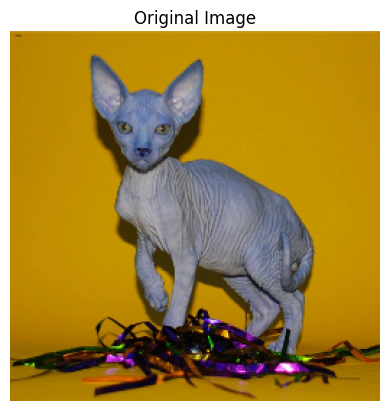

In [47]:
display_image(test_images[0])

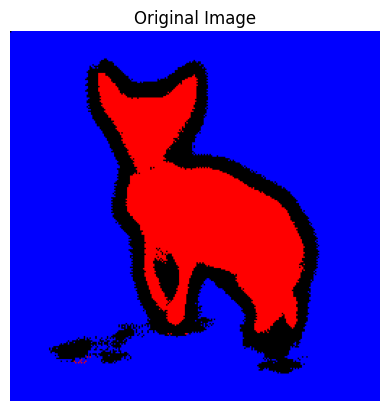

In [48]:
display_image(result)